In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from skimage.util import random_noise
from tqdm.notebook import tqdm
from dataclasses import dataclass
import pandas as pd

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Vision/emotions.zip -d /content/drive/MyDrive/

Archive:  /content/drive/MyDrive/Vision/emotions.zip
  inflating: /content/drive/MyDrive/fer2013/fer2013.csv  


In [ ]:
@dataclass
class Config:
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 10
    num_workers = 2
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_path = "/content/drive/MyDrive/fer2013/fer2013.csv"
    weight_decay = 1e-5 # L2 regularization

config = Config()

In [ ]:
data = pd.read_csv(config.data_path)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
data['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


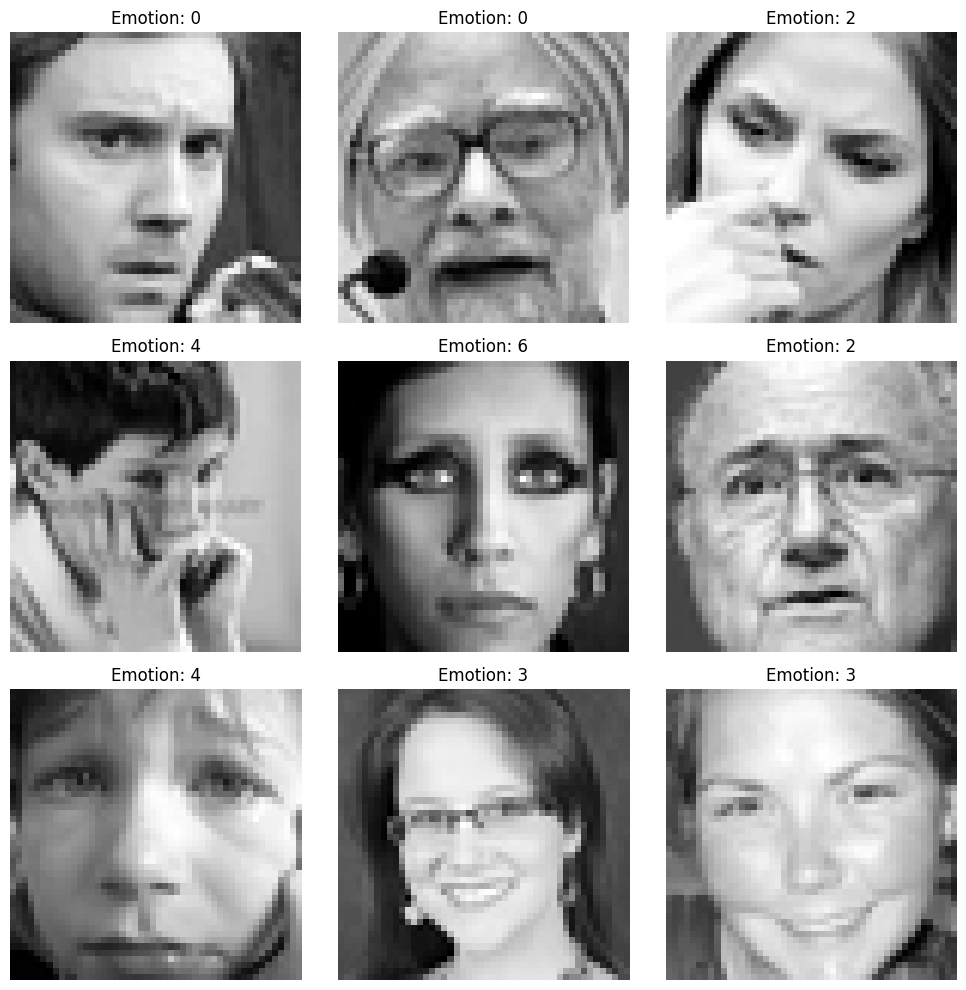

In [ ]:
def process_pixels(pixel_string):
    return np.array(pixel_string.split(), dtype='float32').reshape(48, 48) # Convert the 'pixels' column into NumPy arrays

data['processed_pixels'] = data['pixels'].apply(process_pixels)

# Step 5: Visualize some sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    sample_image = data['processed_pixels'][i]
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Emotion: {data['emotion'][i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def add_salt_and_pepper_noise(image, noise_factor=0.1):
    row, col = image.shape
    noisy_image = np.copy(image)

    # Salt noise (white pixels)
    num_salt = int(noise_factor * row * col)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Pepper noise (black pixels)
    num_pepper = int(noise_factor * row * col)
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

In [ ]:
data['noisy_pixels'] = data['processed_pixels'].apply(lambda x: add_salt_and_pepper_noise(x, noise_factor=0.1))

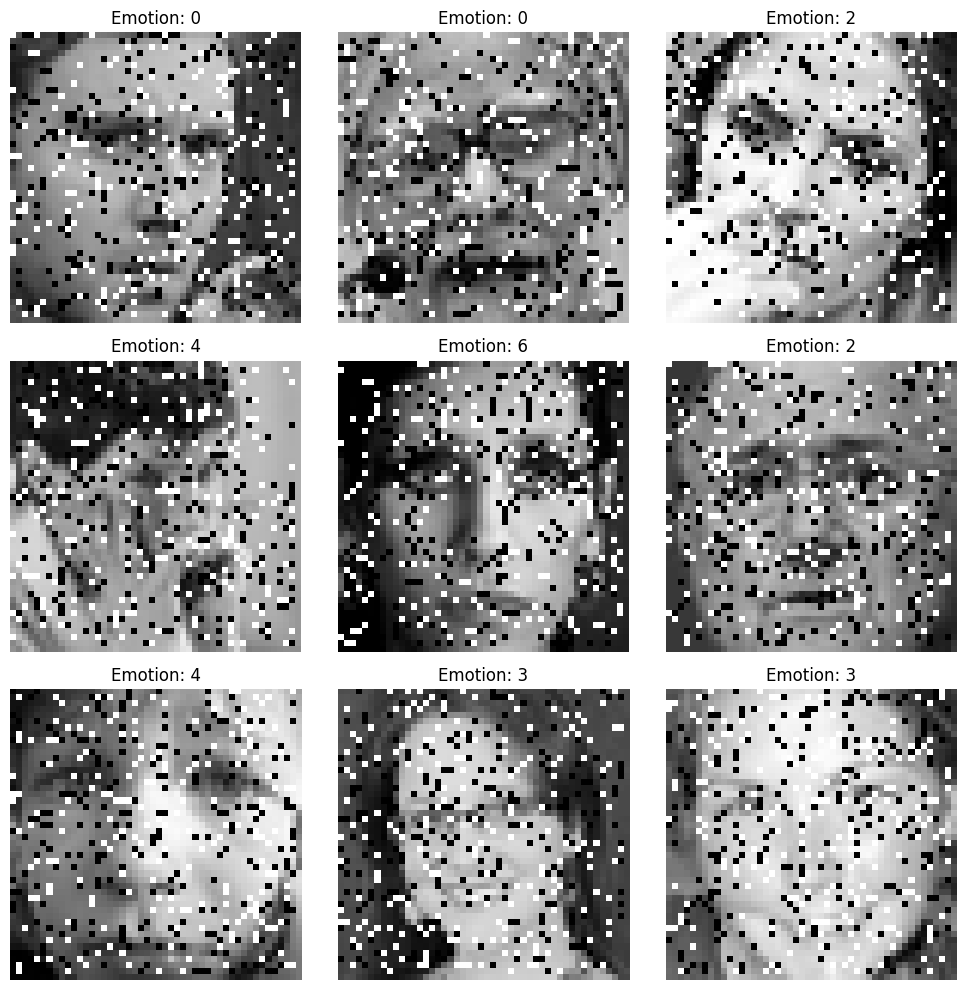

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    sample_image = data['noisy_pixels'][i]
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Emotion: {data['emotion'][i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
train_data = data[data['Usage'] == 'Training']
val_data = data[data['Usage'] == 'PublicTest']
test_data = data[data['Usage'] == 'PrivateTest']

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 28709
Validation set size: 3589
Test set size: 3589


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, noisy_images, clean_images):
        self.noisy_images = noisy_images
        self.clean_images = clean_images

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_image = torch.tensor(self.noisy_images[idx], dtype=torch.float32).unsqueeze(0) / 255.0  # [0...1]
        clean_image = torch.tensor(self.clean_images[idx], dtype=torch.float32).unsqueeze(0) / 255.0  # [0...1]
        return noisy_image, clean_image

In [ ]:
def create_dataloader(data=train_data):
  X_train_noisy = np.array(data['noisy_pixels'].tolist())
  y_train_clean = np.array(data['processed_pixels'].tolist())

  dataset = CustomDataset(X_train_noisy, y_train_clean)
  dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
  return dataloader

train_dataloader, val_dataloader, test_dataloader = [create_dataloader(x) for x in [train_data, val_data, test_data]]

In [ ]:
noise_dataiter = iter(train_dataloader)
data = next(noise_dataiter)
(noise_imgs, clean_imgs) = data
print(clean_imgs.size())

torch.Size([32, 1, 48, 48])


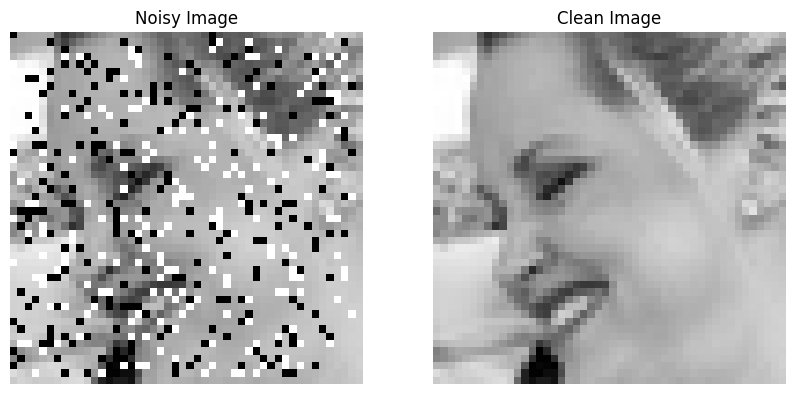

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(noise_imgs[0].squeeze(), cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clean_imgs[0].squeeze(), cmap='gray')
plt.title("Clean Image")
plt.axis('off')

plt.show()

In [ ]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


class DeConv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2):
        super().__init__()
        self.deConv = nn.ConvTranspose2d(in_channels, out_channels, size,
                                         padding=1, stride=2, output_padding=1)
        self.convs = Conv_block(out_channels * 2, out_channels, size, padding, dropout)

    def forward(self, x, residual):
        x = self.deConv(x)
        x = torch.cat([x, residual], 1)
        x = self.convs(x)
        return x


class Unet(nn.Module):
    # initializers
    def __init__(self, d=64, out_channels=1, dropout=0.2):  # Set out_channels to 1
        super().__init__()

        # Unet encoder
        self.conv_blocks = nn.ModuleList([
            Conv_block(1, d, dropout=dropout),  # Change in_channels to 1
            Conv_block(d, 2 * d, stride=2, dropout=dropout),
            Conv_block(2 * d, 4 * d, stride=2, dropout=dropout),
            Conv_block(4 * d, 8 * d, stride=2, dropout=dropout),
            Conv_block(8 * d, 16 * d, stride=2, dropout=dropout)
        ])

        # Unet decoder
        self.deConv_blocks = nn.ModuleList([
            DeConv_block(16 * d, 8 * d, dropout=dropout),
            DeConv_block(8 * d, 4 * d, dropout=dropout),
            DeConv_block(4 * d, 2 * d, dropout=dropout),
            DeConv_block(2 * d, d, dropout=dropout),
        ])

        self.output_conv = nn.Conv2d(d, out_channels, 3, padding=1)  # Set out_channels to 1
        self.float()

    # forward method
    def forward(self, x):
        x1 = self.conv_blocks[0](x)
        x2 = self.conv_blocks[1](x1)
        x3 = self.conv_blocks[2](x2)
        x4 = self.conv_blocks[3](x3)
        x5 = self.conv_blocks[4](x4)

        x = self.deConv_blocks[0](x5, x4)
        x = self.deConv_blocks[1](x, x3)
        x = self.deConv_blocks[2](x, x2)
        x = self.deConv_blocks[3](x, x1)

        x = self.output_conv(x)

        return x

model = Unet()

torch.Size([1, 1, 48, 48])


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

valid_loss_min = np.Inf

model.to(config.device)
history = {'train': [], 'valid': []}
for i in range(config.num_epochs):
    print(f'Epoch {i+1} ...')

    model.train()
    sum_train_mse = 0
    training_steps = 0
    for (x, y) in tqdm(train_dataloader):
        optimizer.zero_grad()

        x = x.to(config.device)
        y = y.to(config.device)

        output = model(x)
        loss = criterion(output, y)

        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for (x, y) in tqdm(val_dataloader):

        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)

        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'UNET-1-0.07.pt')
        valid_loss_min = valid_loss

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Average Train MSE: {sum_train_mse / training_steps}, Average Validation MSE: {sum_valid_mse / valid_steps}')


Epoch 1 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.000958). The new model saved
Epoch 1, Average Train MSE: 0.004080005097311853, Average Validation MSE: 0.0010576452457230637
Epoch 2 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2, Average Train MSE: 0.0025073705816160232, Average Validation MSE: 0.0011593389965643265
Epoch 3 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (0.000958 --> 0.000709). The new model saved
Epoch 3, Average Train MSE: 0.0020675413631512586, Average Validation MSE: 0.0006020490952717981
Epoch 4 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4, Average Train MSE: 0.0018707374967079826, Average Validation MSE: 0.000906617621235978
Epoch 5 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (0.000709 --> 0.000664). The new model saved
Epoch 5, Average Train MSE: 0.00144416362009341, Average Validation MSE: 0.0005923653030726828
Epoch 6 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6, Average Train MSE: 0.0013215323959509396, Average Validation MSE: 0.0006335169387017006
Epoch 7 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (0.000664 --> 0.000437). The new model saved
Epoch 7, Average Train MSE: 0.0012527780236187857, Average Validation MSE: 0.00047443565099697924
Epoch 8 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8, Average Train MSE: 0.0011656147609091466, Average Validation MSE: 0.0003623344172595844
Epoch 9 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9, Average Train MSE: 0.0011472928369903152, Average Validation MSE: 0.0003781490284430308
Epoch 10 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (0.000437 --> 0.000432). The new model saved
Epoch 10, Average Train MSE: 0.0010774212301203686, Average Validation MSE: 0.00044154609214572184
Epoch 11 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11, Average Train MSE: 0.0010794386031590445, Average Validation MSE: 0.0025168857743254804
Epoch 12 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (0.000432 --> 0.000252). The new model saved
Epoch 12, Average Train MSE: 0.0010007632876728725, Average Validation MSE: 0.00032241092927844583
Epoch 13 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13, Average Train MSE: 0.000961396618012986, Average Validation MSE: 0.0003541699271706815
Epoch 14 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14, Average Train MSE: 0.0009258977470158252, Average Validation MSE: 0.0005857312641790615
Epoch 15 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15, Average Train MSE: 0.000905751871846861, Average Validation MSE: 0.0003440404468961884
Epoch 16 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 16, Average Train MSE: 0.000896120127103808, Average Validation MSE: 0.00041041015188902024
Epoch 17 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Validation loss decreased (0.000252 --> 0.000226). The new model saved
Epoch 17, Average Train MSE: 0.0008201188370113557, Average Validation MSE: 0.0003717517409683823
Epoch 18 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18, Average Train MSE: 0.0008212614249394489, Average Validation MSE: 0.000429360229991772
Epoch 19 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19, Average Train MSE: 0.0007970208205041042, Average Validation MSE: 0.0003010428074563944
Epoch 20 ...


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 20, Average Train MSE: 0.000784984205702718, Average Validation MSE: 0.00033093698269201326


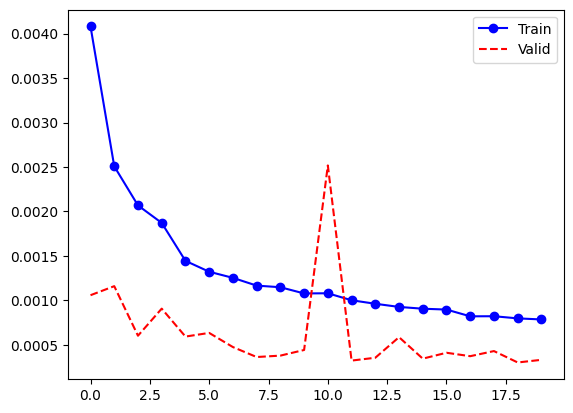

In [ ]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

In [ ]:
drive_model_path = '/content/drive/My Drive/Vision/unet_model.pth'
torch.save(model.state_dict(), drive_model_path)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_metrics(denoised_imgs, clean_imgs):
    psnr_values = []
    ssim_values = []

    for denoised, clean in zip(denoised_imgs, clean_imgs):
        denoised = denoised.squeeze()
        clean = clean.squeeze()

        psnr = peak_signal_noise_ratio(clean, denoised, data_range=1.0)
        psnr_values.append(psnr)

        ssim = structural_similarity(clean, denoised, data_range=1.0)
        ssim_values.append(ssim)

    return np.mean(psnr_values), np.mean(ssim_values)

PSNR: 35.26 dB
SSIM: 0.9821


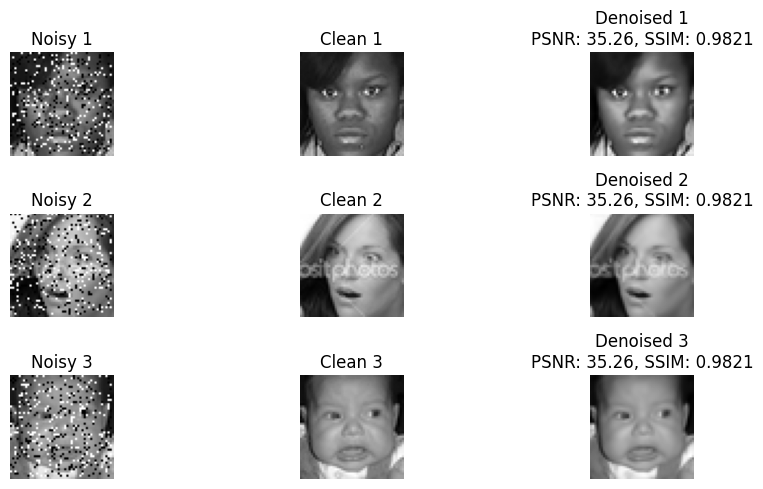

In [ ]:
model.eval()

test_dataiter = iter(test_dataloader)
data = next(test_dataiter)
(noise_imgs, clean_imgs) = data

noise_imgs = noise_imgs.to(config.device)
clean_imgs = clean_imgs.to(config.device)

# Forward pass through the model to get the denoised images
with torch.no_grad():
    denoised_imgs = model(noise_imgs)

# convert to numpy for visualization
denoised_imgs = denoised_imgs.cpu().numpy()
clean_imgs = clean_imgs.cpu().numpy()

# Normalize images to [0, 1] range
denoised_imgs = np.clip(denoised_imgs, 0, 1)
clean_imgs = np.clip(clean_imgs, 0, 1)

psnr, ssim = calculate_metrics(denoised_imgs, clean_imgs)

print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(noise_imgs[i].cpu().numpy().squeeze(), cmap='gray')
    plt.title(f"Noisy {i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(clean_imgs[i].squeeze(), cmap='gray')
    plt.title(f"Clean {i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(denoised_imgs[i].squeeze(), cmap='gray')
    plt.title(f"Denoised {i+1}\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
